In [112]:
# ------------------------- Regression Model: Every Country ----------------------------------
# Doesn't work with China, Canada, USA*
# A separate model for Canadian Provincial Analysis is also available

In [116]:
# Enter name of country here
x = 'Spain'
# Enter the day in April you want to forecast till
day = 21

In [117]:
# Run the forecasting script below (I have combined all the cells)
# The output is the prediction till the desired day in April (by the Linear Regressor/XGB Regressor)

/Users/zacblac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zacblac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zacblac/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/us

[19:02:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:02:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


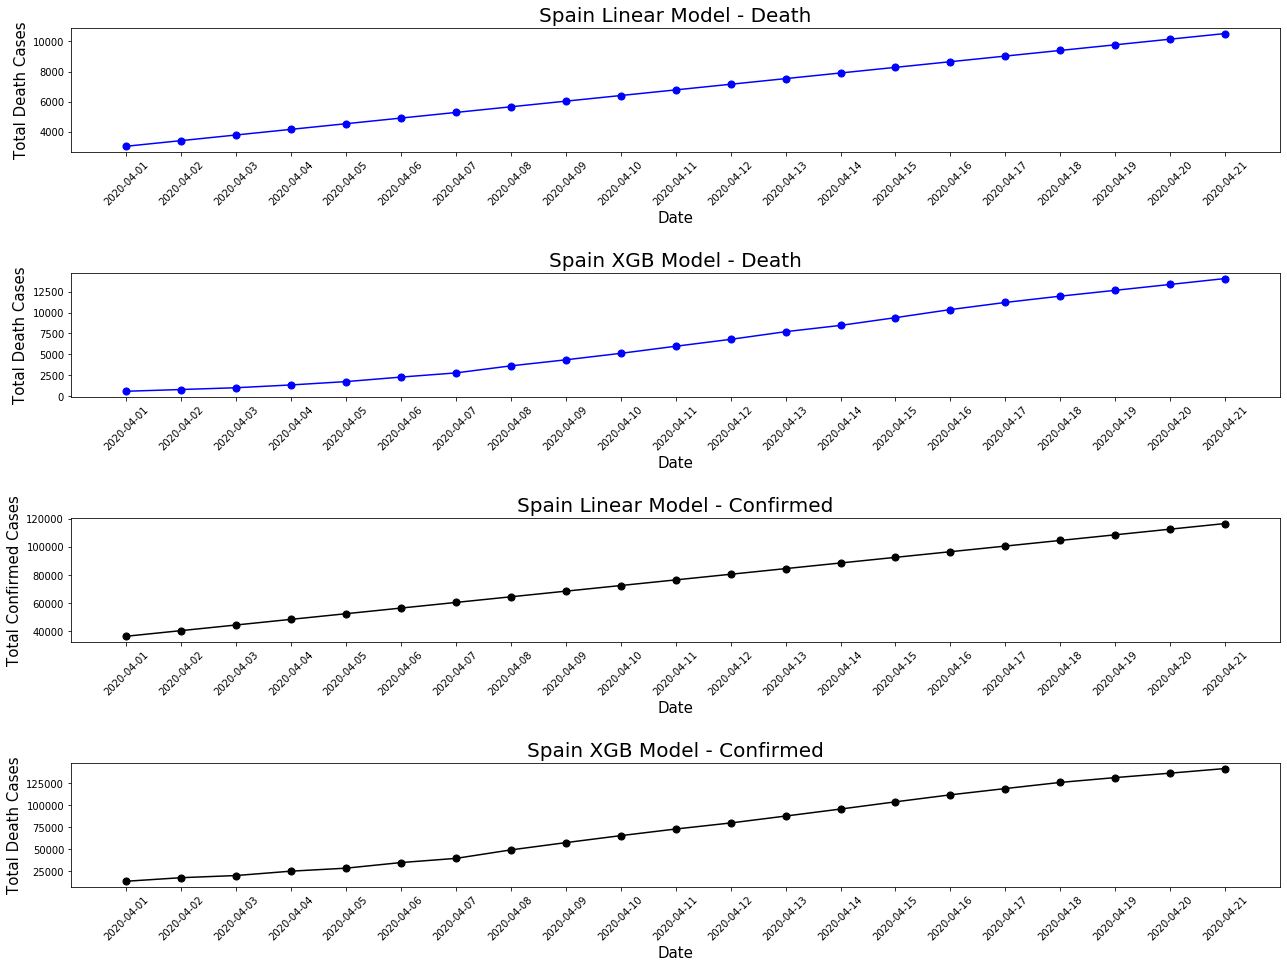

In [118]:
#----------------------------------forecast code:------------------------

# Importing required libraries

import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Reading in data

df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')

# Training data for country
Country1 = df1[df1.Country_Region==x]

# Test data for Spain
Country2 = df2[df2.Country_Region==x]

# We can train for less data until the 7th of April (can't start earlier because regression will predict less accurately)
Country1 = Country1[(Country1['Date'] >= '2020-03-01') & (Country1['Date'] <= '2020-04-07')]
Country1['day_count'] = list(range(1,len(Country1)+1)) 
day2 = day+17

# Copy the training data
Country_exp = Country1.copy()
# Selecting the features to target
features = ['Id', 'Country_Region', 'Province_State', 'ConfirmedCases', 'Fatalities','day_count']
Country_exp = Country_exp[features]
Country_exp[['ConfirmedCases', 'Fatalities']] = Country_exp[['ConfirmedCases', 'Fatalities']]
# Type casting
Country_exp[['ConfirmedCases', 'Fatalities']] = Country_exp[['ConfirmedCases', 'Fatalities']].astype('float64')

# Encode the features
le = LabelEncoder()
le.fit(Country_exp['Country_Region'].astype(str))
le.fit(Country_exp['Province_State'].astype(str))

# Training set
x_train = Country_exp.drop(['ConfirmedCases', 'Fatalities'], axis=1)
x_train.drop('Id', inplace=True, errors='ignore', axis=1)
x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
x_train.drop('Country_Region', inplace=True, errors='ignore', axis=1)
x_train.drop('Province_State', inplace=True, errors='ignore', axis=1)

# Training sets for confirmed cases and fatalities
y_train_1 = Country_exp['ConfirmedCases']
y_train_2 = Country_exp['Fatalities']

# Test sets
Country2['day_count'] = list(range(1,len(Country2)+1)) 
Country2['day_count'] = Country2.day_count + 11
x_test = Country2
x_test.drop('Province_State', inplace=True, errors='ignore', axis=1)
x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
x_test.drop('Country_Region', inplace=True, errors='ignore', axis=1)
x_test.drop('Date', inplace=True, errors='ignore', axis=1)

# Day 18 is april 1, Day 47 is April 30
x_test = x_test[(x_test['day_count']<=day2) & (x_test['day_count']>=18)];

# Model Training - XGB Regressor

from xgboost import XGBRegressor

xgcovid_model = XGBRegressor(n_estimators=1000)
xgcovid_model_2 = XGBRegressor(n_estimators=1000)

# Confirmed cases training
xgcovid_model.fit(x_train,y_train_1)

# Deaths training
xgcovid_model_2.fit(x_train,y_train_2)

# Prediction for confirmed cases
xgy_pred = xgcovid_model.predict(x_test)

# Prediction for death cases
xgy_pred_2 = xgcovid_model_2.predict(x_test)

# Model Training - Linear Regressor 

covid_model = linear_model.LinearRegression()
covid_model_2 = linear_model.LinearRegression()

# Confirmed cases training
covid_model.fit(x_train,y_train_1)

# Deaths training
covid_model_2.fit(x_train,y_train_2)

# Prediction for confirmed cases
y_pred = covid_model.predict(x_test)

# Prediction for death cases
y_pred_2 = covid_model_2.predict(x_test)

# Selecting the desired predicted time frame
Country3 = pd.read_csv('test.csv')
Country3 = Country3[Country3.Country_Region==x]
Country3['day_count'] = list(range(1,len(Country3)+1)) 
Country3['day_count'] = Country3.day_count + 11
Country3 = Country3[(Country3['day_count'] >= 18) & (Country3['day_count'] <= day2)]

# Plotting the confirmed cases and deaths from 31st March to April 15th
Country3['Confirmed'] = y_pred
Country3['Deaths'] = y_pred_2
Country3['XG-Confirmed'] =xgy_pred
Country3['XG-Death'] =xgy_pred_2

# Plots
fig, ax = plt.subplots(4, 1,figsize=(20,15))
fig.tight_layout(pad=10.0)

# Linear Regressor - Death
ax[0].set_title(x + ' Linear Model - Death',fontsize=20)
ax[0].scatter(x='Date',y='Deaths',data=Country3,s=50,color='blue')
ax[0].plot('Date','Deaths',data=Country3,color='blue')
ax[0].set_xlabel('Date', fontsize=15)
ax[0].set_ylabel('Total Death Cases', fontsize=15)
ax[0].set_xticklabels(Country3.Date,fontsize=10,rotation=45)

# XGB Regressor - Death
ax[1].set_title(x + ' XGB Model - Death',fontsize=20)
ax[1].scatter(x='Date',y='XG-Death',data=Country3,s=50,color='blue')
ax[1].plot('Date','XG-Death',data=Country3,color='blue')
ax[1].set_xlabel('Date', fontsize=15)
ax[1].set_ylabel('Total Death Cases', fontsize=15)
ax[1].set_xticklabels(Country3.Date,fontsize=10,rotation=45)

# Linear Regressor - Confirmed
ax[2].set_title(x + ' Linear Model - Confirmed',fontsize=20)
ax[2].scatter(x='Date',y='Confirmed',data=Country3,s=50,color='black')
ax[2].plot('Date','Confirmed',data=Country3,color='black')
ax[2].set_xlabel('Date', fontsize=15)
ax[2].set_ylabel('Total Confirmed Cases', fontsize=15)
ax[2].set_xticklabels(Country3.Date,fontsize=10,rotation=45);

# XGB Regressor - Confirmed
ax[3].set_title(x + ' XGB Model - Confirmed',fontsize=20)
ax[3].scatter(x='Date',y='XG-Confirmed',data=Country3,s=50,color='black')
ax[3].plot('Date','XG-Confirmed',data=Country3,color='black')
ax[3].set_xlabel('Date', fontsize=15)
ax[3].set_ylabel('Total Death Cases', fontsize=15)
ax[3].set_xticklabels(Country3.Date,fontsize=10,rotation=45);
